# Tarea 6. Descrappify
## Arnoldo Fernando Chue Sánchez

**Indicaciones**

Crea una red neuronal que suba la resolución de imágenes de 32x32 a 96x96 En general las ideas son las mismas para hacer imágenes más grandes

En este caso sí vamos a intentar con imágenes de más alta resolución (hasta que la GPU aguante)

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torchvision as tv
import fastai.vision.all as fv
from pathlib import Path
from math import prod 

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Vamos a cargar nuestras imágenes (pero como al entrenar nos dio un error raro de imágenes corruptas vamos a verificar eso desde este punto)

In [3]:
from PIL import Image

def verificacion(imagen):
    try:
        with Image.open(imagen) as img: img.verify()  
        return True
    except (IOError, SyntaxError):
        return False

In [4]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size)

    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.ImageBlock), # tomamos los dos bloques porque uno es donde cargamos las imagenes originales y el segundo es con el que vamos a reproducir la de alta resolución
                        get_items = lambda path: [f for f in fv.get_image_files(path) if verificacion(f)], # cargamos las imágenes directo del folder y las verificamos
                        get_y     = lambda x: x, # nuestra y es nuestra propia imagen (reconstruida en resolución)
                        splitter  = fv.RandomSplitter(valid_pct=0.2),
                        item_tfms = fv.Resize(2*img_size),
                        batch_tfms = tfms,
                        )
    
    return data.dataloaders(folder, bs=batch_size)

Comenzemos con los 96x96 para experimentar y después lo hacemos con resoluciones más altas

In [5]:
dls = load_data("Anime", 96, 64)

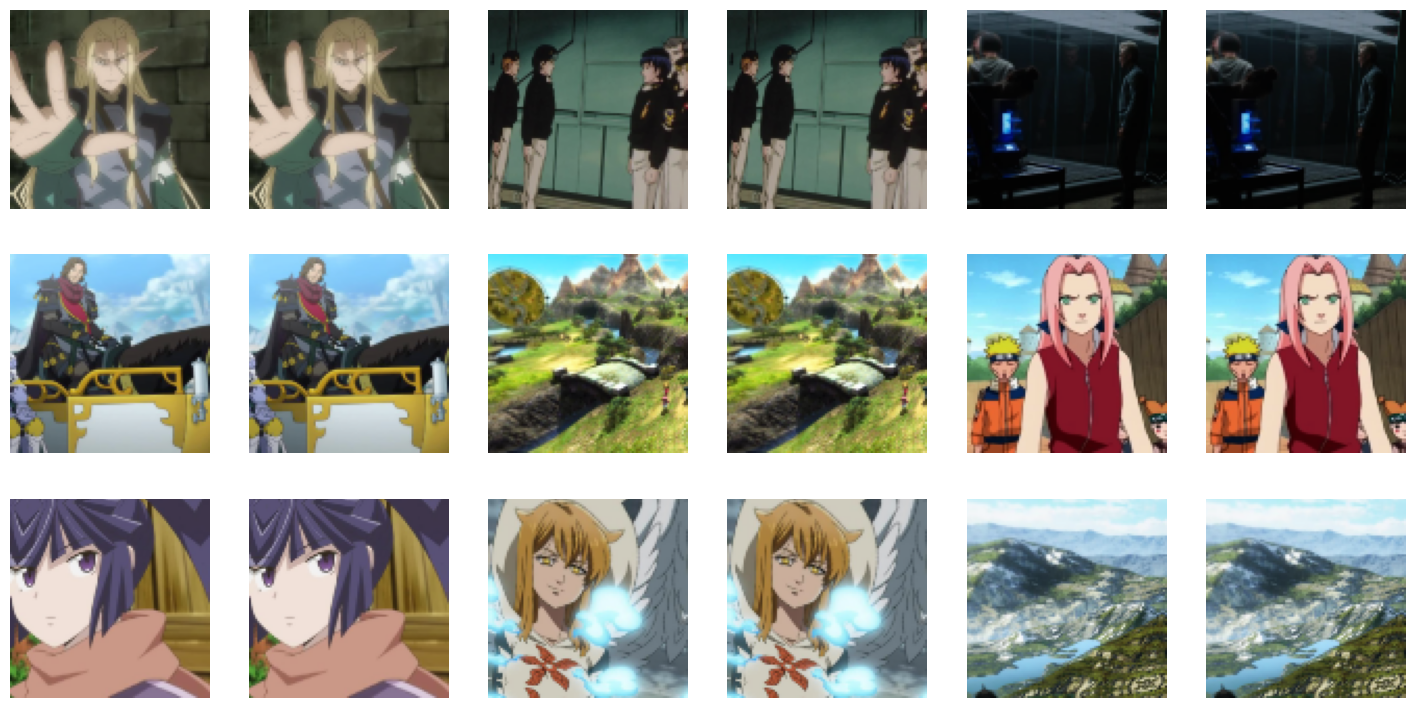

In [6]:
dls.show_batch()

Ahora necesitamos crear un bloque inicial para nuestra red neuronal que baje la resolución.

Recordemos cómo funciona este método:
- Tenemos las imágenes originales con cierta resolución
- Nuestro objetivo es bajarles la resolución para tener tanto la original (alta resolución) como la de baja calidad para el entrenamiento
- Teniendo ambas imágenes podemos usar una unet: la imagen mala se puede reconstruir con esta arquitectura dándoles la original 
- Por lo que el primer paso es un bloque que le baje la resolución

Sin embargo, hay un error que debemos evitar (que ya me pasó pero lo pongo aquí en las notas). Bajar la resolución no es lo mismo a simplemente bajar el tamaño. Si solamente bajamos el tamaño la unet tendrá errores porque tendremos tensores de bs * 3 * 96 * 96 vs tensores de bs * 3 * 32 * 32 y nos marcará error.

Por lo que bajaremos la resolución y luego subiremos al tamaño original. Se perderá la información de la resolución, pero mantendremos las dimensiones del batch

In [7]:
class ToLowResolution(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Investigué formas de bajar la resolución y muchas hablan de la interpolación
        # En este caso tomé la función que ya tenemos un torch y le bajé a un tercio como tenemos en la actividad
        low = F.interpolate(x, scale_factor=1/3) # bajamos la resolución
        return F.interpolate(low, scale_factor=3) # devolvemos al tamaño original ya con menos resolución

In [8]:
x, y = dls.one_batch()

In [9]:
low = ToLowResolution()
low(x).shape

torch.Size([64, 3, 96, 96])

In [10]:
to_image = tv.transforms.ToPILImage()

*Original*

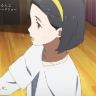

In [11]:
to_image(x[0])

*Baja resolución*

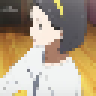

In [12]:
to_image(low(x)[0])

Vemos que nuestro bloque sí funciona

Por lo que ya casi estamos listos para crear la arquitectura de la Unet

In [13]:
learn1 = fv.unet_learner(
    dls,
    fv.models.resnet18,
    n_out=3, # en las unet debemos decirle el numero de salidas (en este caso canales de la imagen)
    normalize=False,
    loss_func=F.mse_loss,
    cbs=fv.GradientClip(),
    opt_func=fv.ranger
).to_fp16()

Modificamos la arquitectura incorporando al inicio 

In [14]:
learn1.model = nn.Sequential(
    ToLowResolution(),
    learn1.model
)

SuggestedLRs(valley=6.30957365501672e-05)

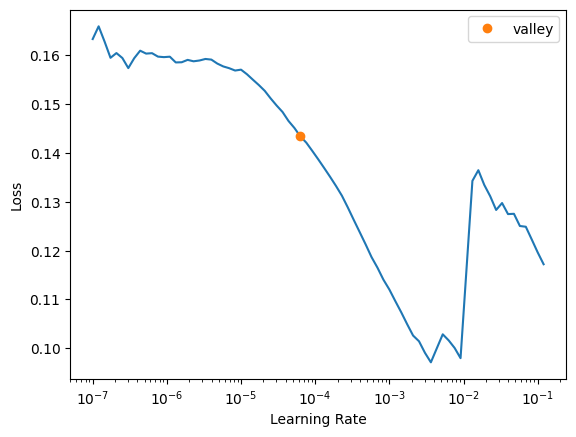

In [15]:
learn1.lr_find()

Pasamos a este primer entrenamiento para ver los resultados con este experimento en resoluciones pequeñas

In [16]:
learn1.fit_one_cycle(10, 0.0001, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,time
0,0.009894,0.008528,01:03
1,0.006567,0.006449,01:03
2,0.005653,0.005706,01:04
3,0.005229,0.005390,01:04
4,0.005091,0.005306,01:04
5,0.004857,0.005019,01:04
6,0.004786,0.004947,01:03
7,0.004660,0.004845,01:03
8,0.004578,0.004813,01:03
9,0.004531,0.004788,01:04


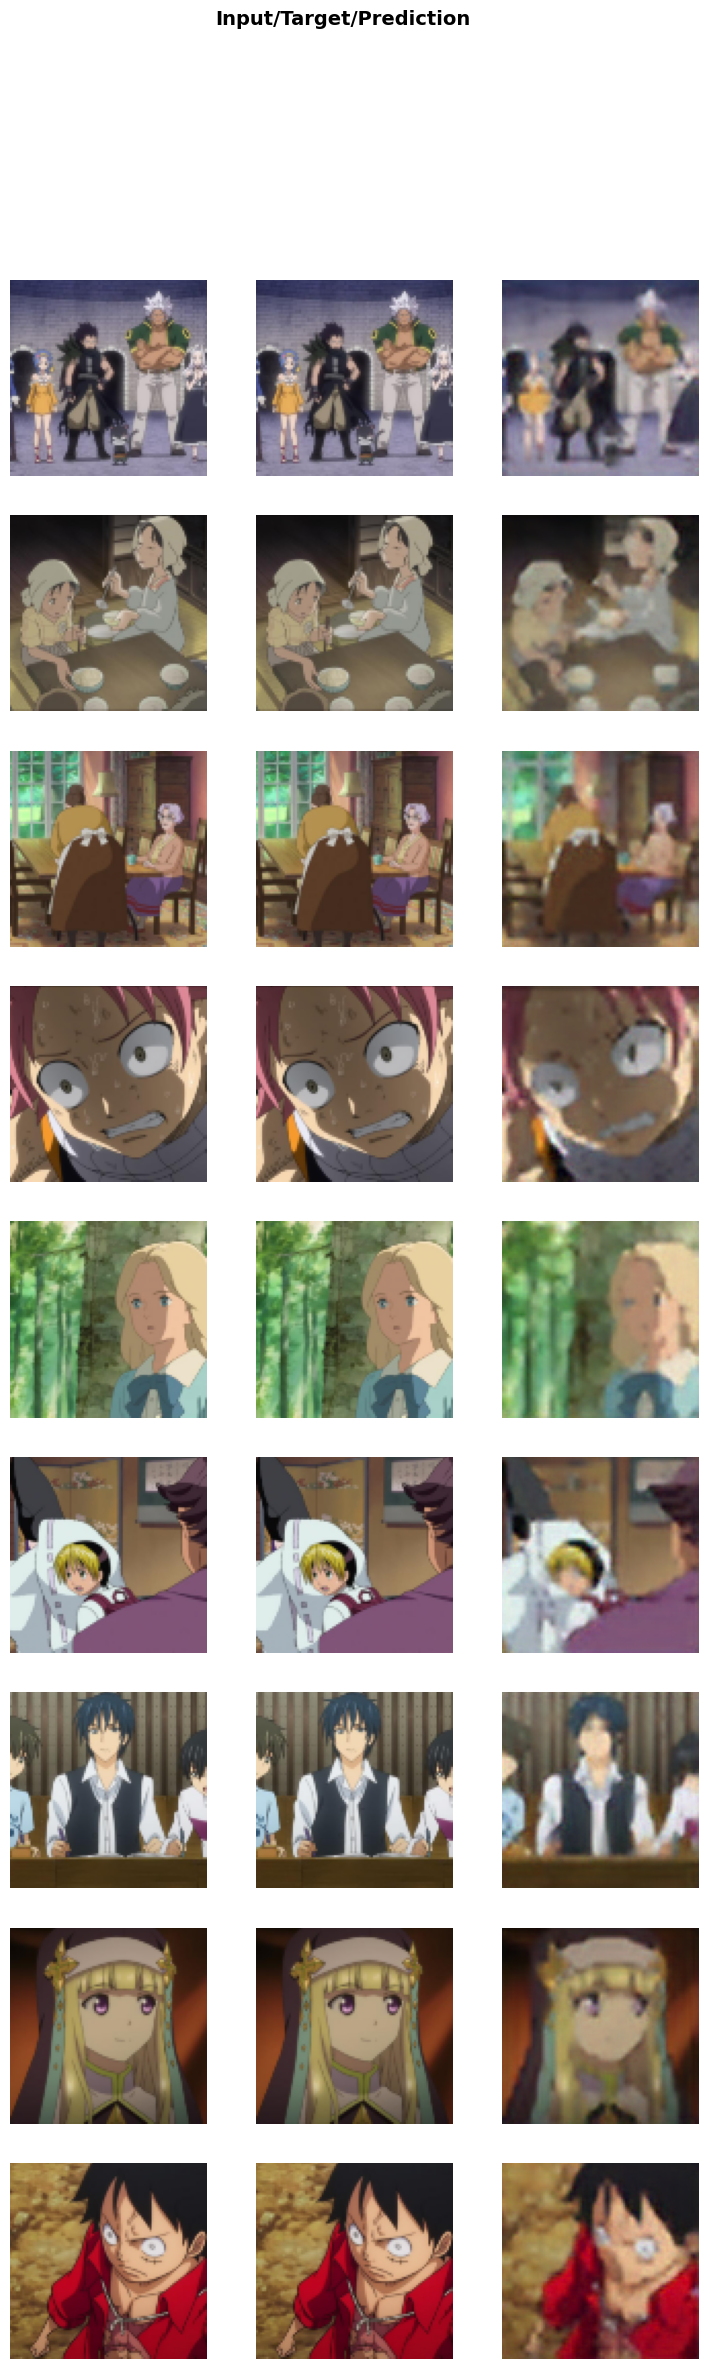

In [17]:
learn1.show_results()

Lo primero que podemos observar es que el input y el target se ven igual. La razón de esto es que el input le bajamos la resolución dentro de la red neuronal. Por lo que al visualizar de este modo no vemos el cambio de resolución.

Sin embargo, lo que sí podemos evaluar es qué tan diferentes se quedan las imágenes de la predicción de las objetivo. Es cierto que sí se nota la diferencia porque no alcanzamos la resolución original con solamente 10 épocas. Probablemente si le damos más tiempo para entrenar sí se alcancen mejores resultados. Pero para ir de 32x32 pixeles a la resolución alcanzada obtuvimos buenos resultados: se ve como desenfocado o sin tanto detalle, pero no al punto de pixeleado o que veamos los cuadros.

Vamos a intentar entonces con resoluciones más altas, más épocas y si nuestro equipo lo permite una mejor arquitectura

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torchvision as tv
import fastai.vision.all as fv
from pathlib import Path
from math import prod 
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
def verificacion(imagen):
    try:
        with Image.open(imagen) as img: img.verify()  
        return True
    except (IOError, SyntaxError):
        return False
    
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size)

    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.ImageBlock), # tomamos los dos bloques porque uno es donde cargamos las imagenes originales y el segundo es con el que vamos a reproducir la de alta resolución
                        get_items = lambda path: [f for f in fv.get_image_files(path) if verificacion(f)], # cargamos las imágenes directo del folder y las verificamos
                        get_y     = lambda x: x, # nuestra y es nuestra propia imagen (reconstruida en resolución)
                        splitter  = fv.RandomSplitter(valid_pct=0.2),
                        item_tfms = fv.Resize(2*img_size),
                        batch_tfms = tfms,
                        )
    
    return data.dataloaders(folder, bs=batch_size)

Vamos a intentar con 256x256

In [7]:
dls = load_data("Anime", 256, 64)

In [8]:
class ToLowResolution(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        low = F.interpolate(x, scale_factor=1/8) # bajamos la resolución a 32x32
        return F.interpolate(low, scale_factor=8) # devolvemos al tamaño original ya con menos resolución

In [9]:
learn2 = fv.unet_learner(
    dls,
    fv.models.resnet34, # mejoramos a resnet34 en lugar de 18
    n_out=3, 
    normalize=False,
    loss_func=F.mse_loss,
    cbs=fv.GradientClip(),
    opt_func=fv.ranger
).to_fp16()

learn2.model = nn.Sequential(
    ToLowResolution(),
    learn2.model
)

SuggestedLRs(valley=0.00013182566908653826)

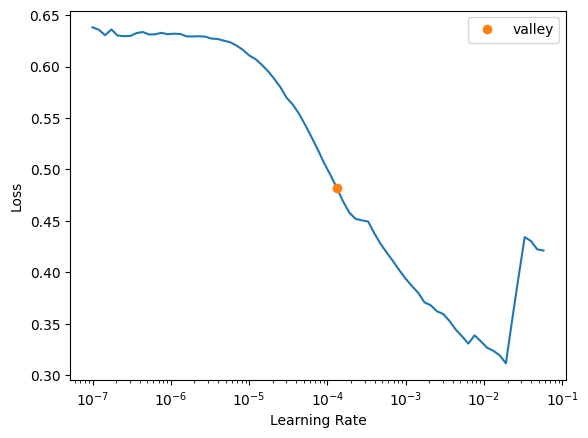

In [10]:
learn2.lr_find()

In [11]:
learn2.fit_one_cycle(20, 0.0001, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,time
0,0.012331,0.011664,02:37
1,0.009436,0.010108,02:38
2,0.008638,0.009303,02:38
3,0.008395,0.009020,02:38
4,0.008093,0.008825,02:35
5,0.007868,0.008461,02:38
6,0.007746,0.008561,02:39
7,0.007624,0.008300,02:39
8,0.007492,0.008202,02:39
9,0.007561,0.008082,02:39


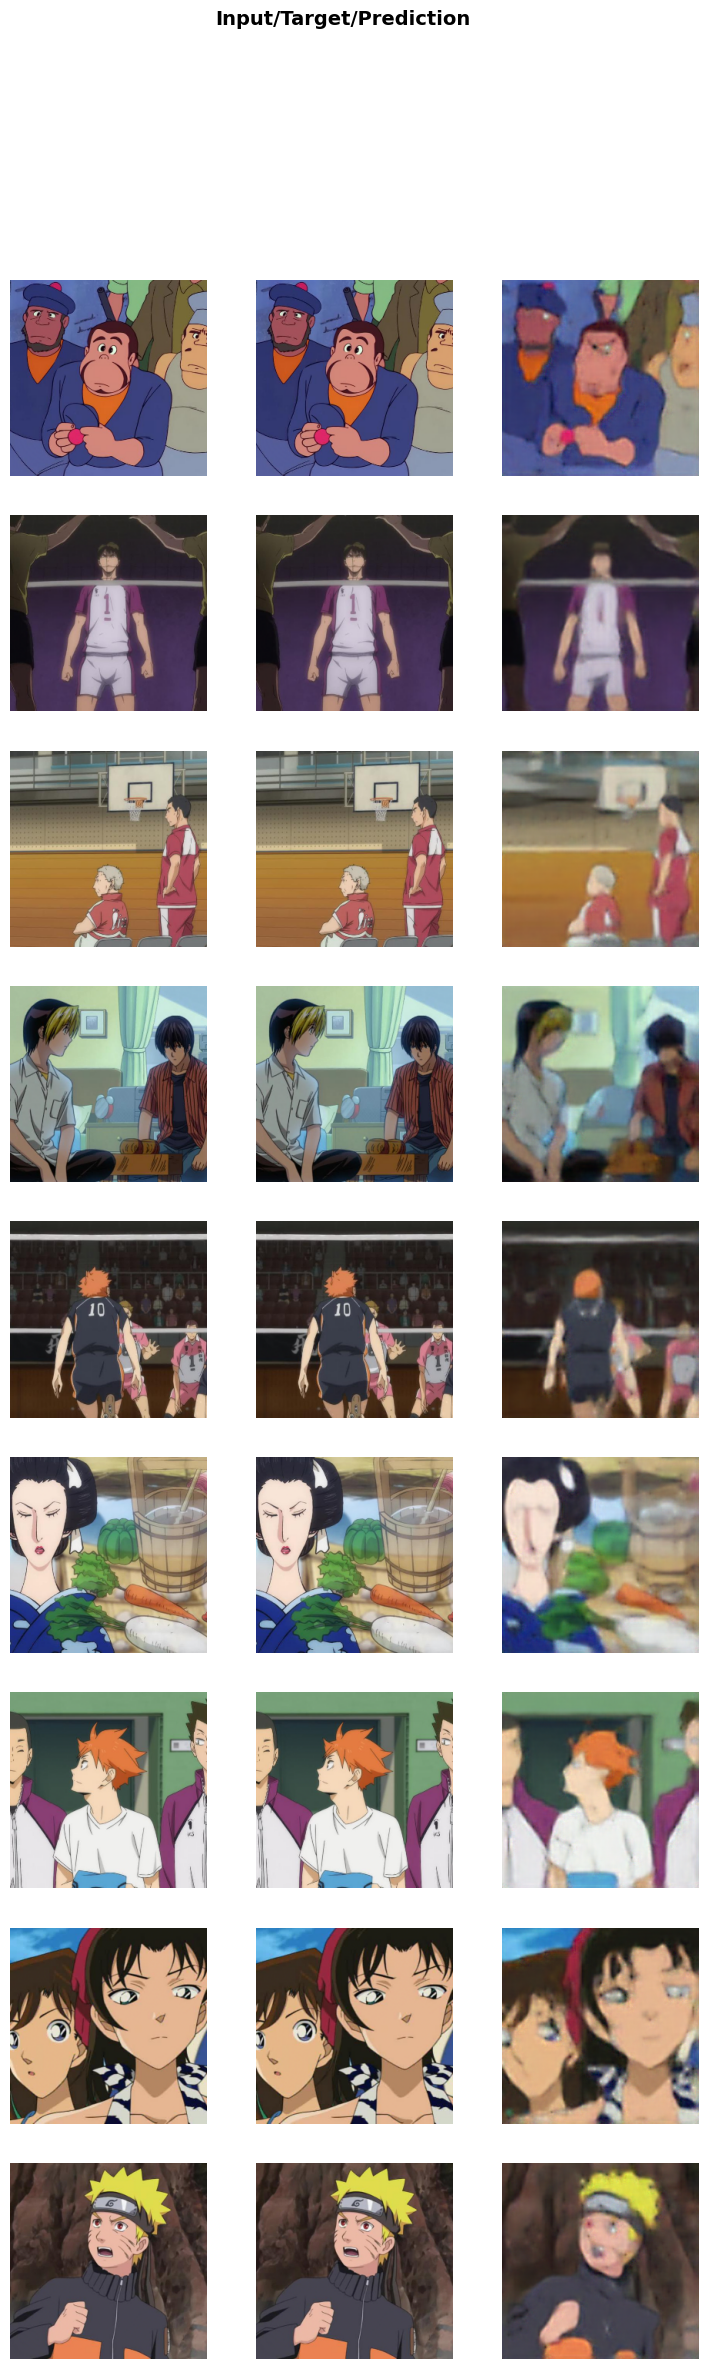

In [12]:
learn2.show_results()

En este caso teníamos un reto mucho más grande: pasar de 32x32 hasta 256x256. Por lo que la información que tenía que reconstruir era muchísima. Por lo tanto, los resultados que tenemos (aunque algunos de ellos se vean mal) son bastante buenos porque justo la red neuronal está recuperando ya algunos detalles.